# Immersic
> Generation of ambient music using a LSTM

- This project aims to be able to seamlessly generate ambient music, by training a LSTM model on a dataset of ambient music. The model will be able to generate music that is similar to the input dataset, but not identical. This will allow for the generation of new music that is unique, but still in the style of the input dataset.
- The dataset used for training is a collection of ambient music MIDI files, which can be found [here](https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip).

# Setup
### Non-GPU Setup
- To run this project without a GPU, you may have any version of Python3 that supports TensorFlow. You can download it from [here](https://www.python.org/downloads/).
- Run `pip install -r requirements.txt` to install the required libraries.

### GPU Setup
- To run this project with a GPU, you need to have a CUDA-compatible GPU and the appropriate drivers installed.
- To avoid any compatibility issues/interference, it is recommended to create a new conda environment, and install the required libraries in that environment.
- It is recommended to use the [Anaconda Navigator](https://www.anaconda.com/download/success) instead of [Miniconda](https://docs.anaconda.com/free/miniconda/), as it comes with all the necessary packages pre-installed.
- For the steps mentioned above, you can find the installation instructions [here](https://www.tensorflow.org/install/gpu).

# Step 0: Preprocessing
- The first step is to preprocess the MIDI files in the dataset. This involves converting the MIDI files into a format that can be used by the model.
- Preprocessing is done in a separate notebook, due to the memory-intensive nature of the process.
- More info about this step can be found in the `Preprocessing.ipynb` notebook.

# Step 1: Import necessary libraries
- The main libraries used in this project are `music21` and `tensorflow`.
- `music21` is used to parse the MIDI files and extract the notes and chords.
- `tensorflow` is used to train the LSTM model.
- Other libraries needed are imported as shown below.
 

In [17]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM, Bidirectional
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.callbacks import ModelCheckpoint
import json
import pickle
from pathlib import Path
from music21 import converter, instrument, note, chord, stream

# Step 2: Check if a GPU is available
- If a GPU is available, the code will use it for training the LSTM model (faster). Else, it will use the CPU by default.
- The code checks if a GPU is available, and memory growth is limited to grow only as needed.

In [2]:
# Perform prerequisite checks
print(f"TensorFlow Version: {tf.__version__}")

physical_devices = tf.config.list_physical_devices('GPU')
print(f"Number of GPUs: {len(physical_devices)}")

if len(physical_devices) > 0: 
    # Configure GPU growth (optional)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU Available: True")
else:
    print("GPU Available: False")

TensorFlow Version: 2.10.1
Number of GPUs: 1
GPU Available: True


# Step 3: Use preprocessed data
- The preprocessed data is loaded from the `notes.json` file.
- The data is then processed to create the input and output sequences for the LSTM model.

In [3]:
# Read the list from the file
with open('notes_immersic.json', 'r') as file:
    notes = json.load(file)

with open('notesImmersic', 'wb') as filepath:
  pickle.dump(notes, filepath)

notes

['8.1',
 '3.4.8.11',
 'F#5',
 'B4',
 '6.11',
 '10.1.3.6',
 'F#5',
 'C#5',
 '8.1',
 '3.4.8.11',
 'F#5',
 'B4',
 '10.11.1.3.6',
 'G#3',
 '0.3.6.9',
 'G#5',
 'F#5',
 '4.6.7.11',
 'G3',
 'E6',
 '7.11',
 'F#6',
 'E6',
 '6.7.11.2',
 '2.7',
 'B5',
 '7.9.1',
 '2.7',
 '6.7.11.1',
 '4.7',
 '6.7',
 '9.1.2',
 'F#6',
 '9.1',
 'F#6',
 '1.4.6.9',
 'A5',
 'E6',
 '9.1',
 '11.3',
 'A5',
 '11.3',
 '3.6.9.11',
 '1.3',
 'B5',
 '4.6.7.11',
 'G3',
 'E6',
 '7.11',
 'F#6',
 'E6',
 '6.7.11.2',
 '2.7',
 'B5',
 '7.9.1',
 '2.7',
 '6.7.11.1',
 '4.7',
 '6.7',
 '9.1.2',
 'F#6',
 '9.1',
 'F#6',
 '1.4.6.9',
 'A5',
 'E6',
 '9.1',
 '11.3',
 'A5',
 '11.3',
 '3.6.9.11',
 '1.3',
 'B5',
 '10.0.2.3.5.7',
 'F5',
 'E-5',
 '3.5.9',
 '2.5.9',
 'A4',
 '9.0.2.5',
 'G4',
 'A4',
 '11.2.5.7',
 'A4',
 'G4',
 '10.0.2.3.5.7',
 'F5',
 'E-5',
 '3.5.9',
 '2.5.9',
 'A4',
 '9.0.2.5',
 'G4',
 'A4',
 '11.2.5.7',
 'A4',
 'G4',
 '11.2.4.7',
 '0',
 '11.0.3.6',
 '9',
 '4.7.9.0',
 '5',
 '4.5.8.11',
 '2',
 '11.2.4.7',
 '0',
 '11.0.3.6',
 '9',
 '4.7.9

In [4]:
# Prepare the sequences used by the neural network
def prepare_sequences(notes, n_vocab):
    sequence_length = 16 # Change this to change the number of notes the model looks at before predicting the next note

    # Get all unique pitchnames
    pitchnames = sorted(set(item for item in notes))

     # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        # sequence_in is a sequence_length list containing sequence_length notes
        sequence_in = notes[i:i + sequence_length]
        # sequence_out is the sequence_length + 1 note that comes after all the notes in
        # sequence_in. This is so the model can read sequence_length notes before predicting
        # the next one.
        sequence_out = notes[i + sequence_length]
        # network_input is the same as sequence_in but it containes the indexes from the notes
        # because the model is only fed the indexes.
        network_input.append([note_to_int[char] for char in sequence_in])
        # network_output containes the index of the sequence_out
        network_output.append(note_to_int[sequence_out])

    # n_patters is the length of the times it was iterated
    # for example if i = 3, then n_patterns = 3
    # because network_input is a list of lists
    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    # Reshapes it into a n_patterns by sequence_length matrix
    print(len(network_input))

    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    # OneHot encodes the network_output
    network_output = to_categorical(network_output)

    return (network_input, network_output)

In [5]:
# Define variables to be used by the model
n_vocab = len(set(notes))
network_input, network_output = prepare_sequences(notes,n_vocab)
n_patterns = len(network_input)
pitchnames = sorted(set(item for item in notes))
numPitches = len(pitchnames)

pitchnames

2807


['0',
 '0.1.3.5.8',
 '0.1.5.8',
 '0.2',
 '0.2.3.5.7',
 '0.2.3.7',
 '0.2.4',
 '0.2.4.7.9',
 '0.2.5',
 '0.3',
 '0.3.5',
 '0.3.5.7',
 '0.3.5.7.8',
 '0.3.5.8',
 '0.3.6',
 '0.3.6.9',
 '0.3.7',
 '0.4',
 '0.4.5',
 '0.4.6',
 '0.4.7',
 '0.4.7.8',
 '0.4.8',
 '0.5',
 '0.6',
 '1',
 '1.2',
 '1.2.4',
 '1.2.4.6.9',
 '1.2.5',
 '1.2.6',
 '1.2.6.9',
 '1.3',
 '1.3.4.8',
 '1.3.6',
 '1.3.6.9',
 '1.3.8',
 '1.4',
 '1.4.6',
 '1.4.6.8.9',
 '1.4.6.9',
 '1.4.7',
 '1.4.8',
 '1.5',
 '1.5.8',
 '1.6',
 '1.7',
 '10.0',
 '10.0.1.5',
 '10.0.2.3.5.7',
 '10.0.2.5',
 '10.0.2.5.7',
 '10.0.3',
 '10.0.5',
 '10.1',
 '10.1.3.6',
 '10.11.1.3.6',
 '10.2',
 '10.2.5',
 '11',
 '11.0',
 '11.0.2',
 '11.0.2.4.7',
 '11.0.2.6',
 '11.0.3.6',
 '11.0.4',
 '11.0.4.7',
 '11.1',
 '11.1.2.6',
 '11.1.3.6',
 '11.1.4.7',
 '11.1.5',
 '11.1.6',
 '11.2',
 '11.2.3.5',
 '11.2.4',
 '11.2.4.6.7',
 '11.2.4.7',
 '11.2.5',
 '11.2.5.7',
 '11.2.5.7.8',
 '11.2.6',
 '11.3',
 '11.3.5',
 '11.3.6',
 '11.4',
 '2',
 '2.3',
 '2.3.5',
 '2.3.6',
 '2.3.7',
 '2.3.7.10',

# Step 4: Create the LSTM model
- The neural network is created with Dropout, LSTM, Dense and Activation layers.
- The LSTM layer is created using the `tensorflow.keras` API.
- The overall model uses checkpoints to save the weights of the model during training, and early stopping to prevent overfitting.


In [6]:
# Create the model
model = Sequential()
model.add(Dropout(0.2))
model.add(LSTM(
    128,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dense(64))
model.add(Dense(64))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(64))
model.add(LSTM(128))
#model.add(Dense(numPitches))
model.add(Dense(numPitches))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [7]:
num_epochs = 500

filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger_1.keras"
checkpoint = ModelCheckpoint(
    filepath, monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint]
with tf.device('/GPU:0'):
    history = model.fit(network_input, network_output, epochs=num_epochs, batch_size=64, callbacks=callbacks_list)

Epoch 1/500
43/44 [============================>.] - ETA: 0s - loss: 5.3358 - accuracy: 0.0298
Epoch 1: loss improved from inf to 5.32667, saving model to weights-improvement-01-5.3267-bigger_1.keras
44/44 [==============================] - 19s 35ms/step - loss: 5.3267 - accuracy: 0.0296
Epoch 2/500
44/44 [==============================] - ETA: 0s - loss: 5.1467 - accuracy: 0.0271
Epoch 2: loss improved from 5.32667 to 5.14671, saving model to weights-improvement-02-5.1467-bigger_1.keras
44/44 [==============================] - 1s 30ms/step - loss: 5.1467 - accuracy: 0.0271
Epoch 3/500
44/44 [==============================] - ETA: 0s - loss: 5.1304 - accuracy: 0.0306
Epoch 3: loss improved from 5.14671 to 5.13043, saving model to weights-improvement-03-5.1304-bigger_1.keras
44/44 [==============================] - 1s 33ms/step - loss: 5.1304 - accuracy: 0.0306
Epoch 4/500
43/44 [============================>.] - ETA: 0s - loss: 5.1008 - accuracy: 0.0363
Epoch 4: loss improved from 5.13

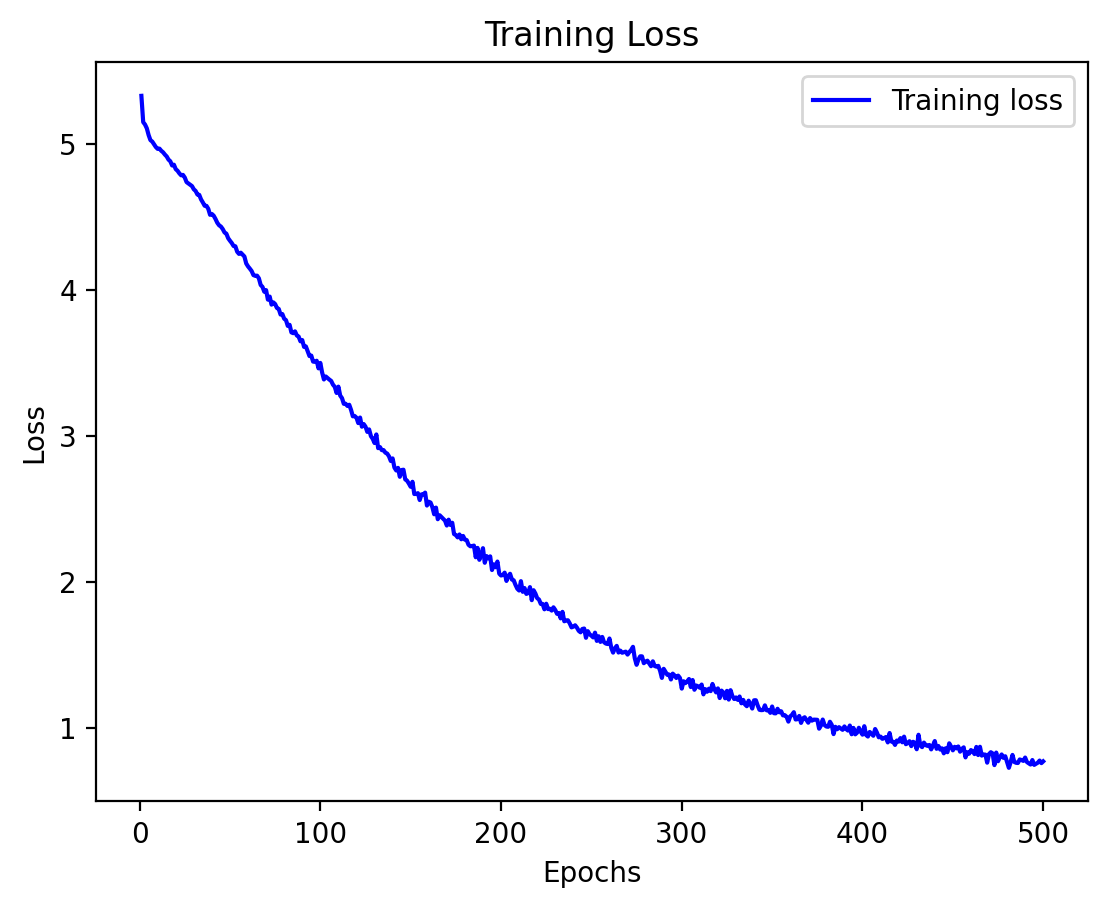

In [23]:
# Plot the loss over time
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)
save_path = 'Data\\Samples'

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(save_path + '/loss.png')
plt.show()

# Step 5: Generate music
- After the model is trained, it can be used to generate music.
- The model generates music by predicting the next note in the sequence, based on the input sequence. This process is started by picking a random sequence from the network's input data.

In [8]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    # Selects a random row from the network_input
    start = np.random.randint(0, len(network_input)-1)
    print(f'start: {start}')
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    # Random row from network_input
    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        # Reshapes pattern into a vector
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        # Standarizes pattern
        prediction_input = prediction_input / float(n_vocab)

        # Predicts the next note
        prediction = model.predict(prediction_input, verbose=0)

        # Outputs a OneHot encoded vector, so this picks the columns
        # with the highest probability
        index = np.argmax(prediction)
        # Maps the note to its respective index
        result = int_to_note[index]
        # Appends the note to the prediction_output
        prediction_output.append(result)

        # Adds the predicted note to the pattern
        pattern = np.append(pattern,index)
        # Slices the array so that it contains the predicted note
        # eliminating the first from the array, so the model can
        # have a sequence
        pattern = pattern[1:len(pattern)]


    return prediction_output

n_vocab = len(set(notes))
pitchnames = sorted(set(item for item in notes))
prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)

start: 33


# Step 6: Create a MIDI file
- The generated music is then saved as a file containing MIDI sequences, which can then be played locally on your machine.
- The `music21` library is again used to create the MIDI file from the generated notes.

In [14]:
# Create a MIDI file from the predicted notes
def create_midi(prediction_output):
    offset = 0
    output_notes = []

    # Create note and chord objects based on the values generated by the model
    for pattern in prediction_output: 
        if ("." in pattern) or pattern.isdigit(): # If pattern is a chord
            notes_in_chord = pattern.split(".")
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else: # If pattern is a note
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # Increase the offset in each iteration, so that notes do not stack
        offset += 1

    midi_stream = stream.Stream(output_notes)
    midi_stream.write("midi", fp="generated.mid")

In [15]:
create_midi(prediction_output)